## Задание 1: Модификация существующих моделей (30 баллов)

### 1.1 Расширение линейной регрессии (15 баллов)
```python
# Модифицируйте существующую линейную регрессию:
# - Добавьте L1 и L2 регуляризацию
# - Добавьте early stopping
```

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from regression_basics.utils import make_regression_data, mse, log_epoch, RegressionDataset

In [62]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_value = None
        self.early_stop = False

    def __call__(self, current_value):
        if self.best_value is None:
            self.best_value = current_value
            return False
        
        if self.mode == 'min':
            improved = current_value < (self.best_value - self.min_delta)
        else:  # mode == 'max'
            improved = current_value > (self.best_value + self.min_delta)
        
        if improved:
            self.best_value = current_value
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop


class LinearRegression(nn.Module):
    def __init__(self, in_features, l1_lambda=0.0, l2_lambda=0.0):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.early_stopping = EarlyStopping()
        
    def init_early_stopping(self, patience=5, min_delta=0.0):
        self.early_stopping = EarlyStopping(patience, min_delta)
        
    def forward(self, x):
        return self.linear(x)
    
    def regularization_loss(self):
        l1_loss = 0.0
        l2_loss = 0.0
        
        for param in self.parameters():
            if self.l1_lambda > 0:
                l1_loss += torch.norm(param, 1)
            if self.l2_lambda > 0:
                l2_loss += torch.norm(param, 2)
                
        return self.l1_lambda * l1_loss + self.l2_lambda * l2_loss
    
    def fit(self, dataloader, criterion, optimizer, epochs=100):
        history = {'loss': []}
        
        for epoch in range(1, epochs + 1):
            self.train()
            total_loss = 0
            
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                y_pred = self(batch_X)
                loss = criterion(y_pred, batch_y) + self.regularization_loss()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(dataloader)
            history['loss'].append(avg_loss)
            
            if self.early_stopping(avg_loss):
                print(f"Early stopping на эпохе {epoch}. Лучший loss: {self.early_stopping.best_value:.4f}")
                break
                
            if epoch % 10 == 0:
                print(f"Epoch {epoch}: loss={avg_loss:.4f}")
        
        return history

if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    # Создаем Dataset и DataLoader
    dataset = RegressionDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Количество батчей: {len(dataloader)}')
    
    # Инициализируем модель и компоненты обучения
    model = LinearRegression(in_features=1, l1_lambda=0.01, l2_lambda=0.01)
    model.init_early_stopping(patience=30, min_delta=0.001)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Обучаем модель
    history = model.fit(dataloader, criterion, optimizer, epochs=100)

Размер датасета: 200
Количество батчей: 7
Epoch 10: loss=0.1100
Epoch 20: loss=0.0749
Epoch 30: loss=0.0676
Epoch 40: loss=0.0668
Epoch 50: loss=0.0687
Epoch 60: loss=0.0675
Early stopping на эпохе 64. Лучший loss: 0.0675


### 1.2 Расширение логистической регрессии (15 баллов)
```python
# Модифицируйте существующую логистическую регрессию:
# - Добавьте поддержку многоклассовой классификации
# - Реализуйте метрики: precision, recall, F1-score, ROC-AUC
# - Добавьте визуализацию confusion matrix
```

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from regression_basics.utils import make_classification_data, accuracy, log_epoch, ClassificationDataset

Размер датасета: 200
Количество батчей: 7
Epoch 10: loss=0.6859, acc=0.5446, precision=0.2600, recall=0.5000, f1=0.3421, roc_auc=1.0000
Epoch 20: loss=0.6038, acc=0.8170, precision=0.8796, recall=0.8281, f1=0.8531, roc_auc=1.0000
Epoch 30: loss=0.5333, acc=0.8973, precision=0.8969, recall=0.8594, f1=0.8778, roc_auc=0.9996
Epoch 40: loss=0.4800, acc=0.9152, precision=0.9228, recall=0.9010, f1=0.9118, roc_auc=0.9996
Epoch 50: loss=0.4430, acc=0.9241, precision=0.9333, recall=0.9167, f1=0.9249, roc_auc=0.9994
Epoch 60: loss=0.4020, acc=0.9286, precision=0.9333, recall=0.9167, f1=0.9249, roc_auc=0.9990
Epoch 70: loss=0.3808, acc=0.9152, precision=0.9333, recall=0.9167, f1=0.9249, roc_auc=0.9989
Epoch 80: loss=0.3539, acc=0.9286, precision=0.9333, recall=0.9167, f1=0.9249, roc_auc=0.9988
Epoch 90: loss=0.3379, acc=0.9152, precision=0.9333, recall=0.9167, f1=0.9249, roc_auc=0.9988
Epoch 100: loss=0.3304, acc=0.9152, precision=0.9407, recall=0.9271, f1=0.9338, roc_auc=0.9986

Финальные метрик

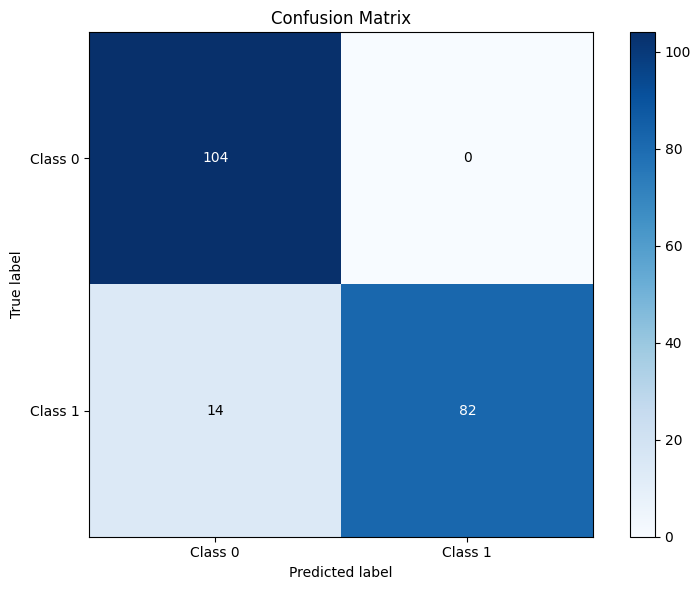

In [65]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        if num_classes == 1:
            self.linear = nn.Linear(in_features, 1)
        else:
            self.linear = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.linear(x)
    
    def predict_proba(self, x):
        """Возвращает вероятности классов"""
        with torch.no_grad():
            logits = self.forward(x)
            if self.num_classes == 1:
                return torch.sigmoid(logits)
            else:
                return torch.softmax(logits, dim=1)
    
    def predict(self, x):
        """Возвращает предсказанные классы"""
        with torch.no_grad():
            if self.num_classes == 1:
                return (self.predict_proba(x) > 0.5).int()
            else:
                return torch.argmax(self.predict_proba(x), dim=1)
    
    def evaluate(self, X, y):
        self.eval()
        y_true = y.cpu().numpy().flatten()
        y_pred = self.predict(X).cpu().numpy().flatten()
        y_proba = self.predict_proba(X).cpu().numpy()
        
        # Confusion matrix
        cm = self.confusion_matrix(y_true, y_pred)
        
        # Precision, Recall, F1, ROC-AUC
        precision = self.precision_score(y_true, y_pred)
        recall = self.recall_score(y_true, y_pred)
        f1 = self.f1_score(y_true, y_pred)
        roc_auc = self.roc_auc_score(y_true, y_proba)
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        }
    
    @staticmethod
    def confusion_matrix(y_true, y_pred):
        """Вычисляет матрицу ошибок"""
        classes = np.unique(np.concatenate((y_true, y_pred)))
        n_classes = len(classes)
        cm = np.zeros((n_classes, n_classes), dtype=int)
        
        for i in range(len(y_true)):
            true_idx = int(y_true[i])
            pred_idx = int(y_pred[i])
            cm[true_idx][pred_idx] += 1
            
        return cm
    
    @staticmethod
    def precision_score(y_true, y_pred):
        """Вычисляет precision"""
        cm = LogisticRegression.confusion_matrix(y_true, y_pred)
        n_classes = cm.shape[0]
        precisions = []
        
        for i in range(n_classes):
            tp = cm[i, i]
            fp = np.sum(cm[:, i]) - tp
            
            if tp + fp == 0:
                precisions.append(0.0)
            else:
                precisions.append(tp / (tp + fp))
                
        return np.mean(precisions)
    
    @staticmethod
    def recall_score(y_true, y_pred):
        """Вычисляет recall"""
        cm = LogisticRegression.confusion_matrix(y_true, y_pred)
        n_classes = cm.shape[0]
        recalls = []
        
        for i in range(n_classes):
            tp = cm[i, i]
            fn = np.sum(cm[i, :]) - tp
            
            if tp + fn == 0:
                recalls.append(0.0)
            else:
                recalls.append(tp / (tp + fn))
                
        return np.mean(recalls)
    
    @staticmethod
    def f1_score(y_true, y_pred):
        """Вычисляет F1-score"""
        precision = LogisticRegression.precision_score(y_true, y_pred)
        recall = LogisticRegression.recall_score(y_true, y_pred)
        
        if precision + recall == 0:
            return 0.0
        
        return 2 * (precision * recall) / (precision + recall)
    
    @staticmethod
    def roc_auc_score(y_true, y_proba):
        """Вычисляет ROC-AUC"""
        classes = np.unique(y_true)
        n_classes = len(classes)
        
        # Для бинарной классификации
        if n_classes == 2:
            # Исправление для бинарного случая с одним выходом
            if y_proba.shape[1] == 1:
                return LogisticRegression._binary_roc_auc(y_true, y_proba.ravel())
            else:
                return LogisticRegression._binary_roc_auc(y_true, y_proba[:, 1])
        
        # Для многоклассовой классификации (One-vs-Rest)
        auc_scores = []
        
        for c in classes:
            # Бинаризуем метки для текущего класса
            y_true_binary = (y_true == c).astype(int)
            y_score = y_proba[:, c]
            
            auc = LogisticRegression._binary_roc_auc(y_true_binary, y_score)
            auc_scores.append(auc)
            
        return np.mean(auc_scores)
    
    @staticmethod
    def _binary_roc_auc(y_true, y_score):
        """Вычисляет ROC-AUC для бинарной классификации"""
        # Сортируем по убыванию вероятности
        indices = np.argsort(y_score)[::-1]
        y_true_sorted = y_true[indices]
        
        # Считаем количество положительных и отрицательных примеров
        n_pos = np.sum(y_true)
        n_neg = len(y_true) - n_pos
        
        if n_pos == 0 or n_neg == 0:
            return 0.5
        
        # Вычисляем количество накопленных положительных и отрицательных
        tpr = []  # True Positive Rate
        fpr = []  # False Positive Rate
        tp = 0
        fp = 0
        
        # Порог снижается от самого высокого значения
        prev_score = y_score[indices[0]] + 1  # Гарантируем первый шаг
        for i in range(len(y_true_sorted)):
            current_score = y_score[indices[i]]
            
            # Если оценка изменилась, добавляем текущую точку
            if current_score != prev_score:
                tpr.append(tp / n_pos)
                fpr.append(fp / n_neg)
                prev_score = current_score
            
            if y_true_sorted[i] == 1:
                tp += 1
            else:
                fp += 1
        
        # Добавляем последнюю точку
        tpr.append(tp / n_pos)
        fpr.append(fp / n_neg)
        
        # Вычисляем AUC методом трапеций
        auc = 0.0
        for i in range(1, len(fpr)):
            auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
            
        return auc
    
    @staticmethod
    def plot_confusion_matrix(cm, class_names=None):
        """Визуализирует матрицу ошибок"""
        plt.figure(figsize=(8, 6))
        
        if class_names is None:
            class_names = [str(i) for i in range(len(cm))]
        
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        
        # Добавляем подписи
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         verticalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # Генерируем данные
    X, y = make_classification_data(n=200)
    
    # Исправление: преобразуем y в одномерный тензор
    y = y.view(-1)
    
    # Создаём датасет и даталоадер
    dataset = ClassificationDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    print(f'Размер датасета: {len(dataset)}')
    print(f'Количество батчей: {len(dataloader)}')
    
    # Создаём модель
    model = LogisticRegression(in_features=2, num_classes=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Обучаем модель
    epochs = 100
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_acc = 0
        num_batches = 0
        
        for i, (batch_X, batch_y) in enumerate(dataloader):
            optimizer.zero_grad()
            logits = model(batch_X)
            
            # Исправление: преобразуем batch_y в нужную форму
            batch_y = batch_y.view(-1, 1).float()
            
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            
            # Вычисляем accuracy
            y_pred = torch.sigmoid(logits)
            acc = accuracy(y_pred, batch_y)
            
            total_loss += loss.item()
            total_acc += acc
            num_batches = i + 1
        
        avg_loss = total_loss / num_batches
        avg_acc = total_acc / num_batches
        
        if epoch % 10 == 0:
            # Вычисляем метрики
            # Исправление: преобразуем y в нужную форму для оценки
            metrics = model.evaluate(X, y.view(-1, 1))
            log_epoch(
                epoch, 
                avg_loss, 
                acc=avg_acc,
                precision=metrics['precision'],
                recall=metrics['recall'],
                f1=metrics['f1'],
                roc_auc=metrics['roc_auc']
            )
    
    # Финальная оценка
    metrics = model.evaluate(X, y.view(-1, 1))
    print("\nФинальные метрики:")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-score: {metrics['f1']:.4f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    
    # Визуализация confusion matrix
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    model.plot_confusion_matrix(
        metrics['confusion_matrix'], 
        class_names=['Class 0', 'Class 1']
    )

## Задание 2: Работа с датасетами (30 баллов)

### 2.1 Кастомный Dataset класс (15 баллов)
```python
# Создайте кастомный класс датасета для работы с CSV файлами:
# - Загрузка данных из файла
# - Предобработка (нормализация, кодирование категорий)
# - Поддержка различных форматов данных (категориальные, числовые, бинарные и т.д.)
```

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path_file, numeric_cols, categorical_cols, binary_cols, target_col):
        self.df = pd.read_csv(path_file)
        self.path_file = path_file
        
        # Заполнение пропусков
        for col in numeric_cols:
            self.df[col] = self.df[col].fillna(self.df[col].median())
        for col in categorical_cols:
            self.df[col] = self.df[col].fillna(self.df[col].mode()[0])
        for col in binary_cols:
            self.df[col] = self.df[col].fillna(0)

        # Обработка числовых признаков
        self.scaler = StandardScaler()
        numeric_data = self.scaler.fit_transform(self.df[numeric_cols])

        # Обработка категориальных признаков
        try:
            self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        except TypeError:
            self.encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

        cat_data = self.encoder.fit_transform(self.df[categorical_cols])
        cat_data = np.array(cat_data)

        # Обработка бинарных признаков
        if binary_cols:
            binary_data = self.df[binary_cols].astype(int).values
        else:
            binary_data = np.empty((len(self.df), 0))

        # Обработка целевой переменной
        y_raw = self.df[target_col]
        if y_raw.dtype == 'object':
            self.label_encoder = LabelEncoder()
            y = self.label_encoder.fit_transform(y_raw)
        else:
            y = y_raw.values
        self.y = torch.tensor(y, dtype=torch.float32)

        # Объединение всех признаков
        X = np.concatenate([numeric_data, cat_data, binary_data], axis=1)
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### 2.2 Эксперименты с различными датасетами (15 баллов)
```python
# Найдите csv датасеты для регрессии и бинарной классификации и, применяя наработки из предыдущей части задания, обучите линейную и логистическую регрессию
```

In [5]:
import torch
from torch.utils.data import DataLoader

In [6]:
titanic_dataset = CustomDataset(
        path_file='train.csv',
        numeric_cols=['Age', 'Fare'],
        categorical_cols=['Pclass', 'Sex', 'Embarked'],
        binary_cols=[],
        target_col='Survived'
)

spotify_dataset = CustomDataset(
    path_file='spotify.csv',
    numeric_cols=['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
    categorical_cols=['mode', 'key', 'time_signature', 'track_genre'],
    binary_cols=['explicit'],
    target_col='popularity'
)

In [7]:
def train_model(model, dataloader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")


def fit_model(dataset, batch_size, model, criterion, optimizer):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Training {str(model).split('(')[0]} on {dataset.path_file}")
    train_model(model, dataloader, criterion, optimizer)


if __name__ == '__main__':
    model = LogisticRegression(in_features = titanic_dataset.X.shape[1])
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    fit_model(titanic_dataset, 32, model, criterion, optimizer)
    
    model = LinearRegression(in_features = spotify_dataset.X.shape[1])
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    fit_model(spotify_dataset, 32, model, criterion, optimizer)

Training LogisticRegression on train.csv
Epoch 10/50, Loss: 0.4603
Epoch 20/50, Loss: 0.4510
Epoch 30/50, Loss: 0.4492
Epoch 40/50, Loss: 0.4490
Epoch 50/50, Loss: 0.4493
Training LinearRegression on spotify.csv
Epoch 10/50, Loss: 379.8643
Epoch 20/50, Loss: 379.3190
Epoch 30/50, Loss: 378.9801
Epoch 40/50, Loss: 379.0109
Epoch 50/50, Loss: 378.9381


## Задание 3: Эксперименты и анализ (20 баллов)

### 3.1 Исследование гиперпараметров (10 баллов)
```python
# Проведите эксперименты с различными:
# - Скоростями обучения (learning rate)
# - Размерами батчей
# - Оптимизаторами (SGD, Adam, RMSprop)
# Визуализируйте результаты в виде графиков или таблиц
```

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam, RMSprop
import pandas as pd

In [ ]:
def run_experiment(dataset, model_class, loss_fn, optimizer_class, lr, batch_size, epochs=30):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = model_class(in_features=dataset.X.shape[1])
    optimizer = optimizer_class(model.parameters(), lr=lr)

    history = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            y_pred = model(X_batch)

            if isinstance(loss_fn, nn.BCEWithLogitsLoss):
                y_batch = y_batch.view(-1, 1).float()

            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history.append(avg_loss)
    return history


In [13]:
lrs = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
results = []
optimizers = {
    'SGD': SGD,
    'Adam': Adam,
    'RMSprop': RMSprop
}

# classification (Titanic)
loss_fn_cls = nn.BCEWithLogitsLoss()
for opt_name, opt_class in optimizers.items():
    for lr in lrs:
        for batch in batch_sizes:
            losses = run_experiment(
                dataset=titanic_dataset,
                model_class=LogisticRegression,
                loss_fn=loss_fn_cls,
                optimizer_class=opt_class,
                lr=lr,
                batch_size=batch
            )
            results.append({
                'task': 'classification',
                'optimizer': opt_name,
                'lr': lr,
                'batch_size': batch,
                'final_loss': losses[-1]
            })

# regression (Spotify)
loss_fn_reg = nn.MSELoss()
for opt_name, opt_class in optimizers.items():
    for lr in lrs:
        for batch in batch_sizes:
            losses = run_experiment(
                dataset=spotify_dataset,
                model_class=LinearRegression,
                loss_fn=loss_fn_reg,
                optimizer_class=opt_class,
                lr=lr,
                batch_size=batch
            )
            results.append({
                'task': 'regression',
                'optimizer': opt_name,
                'lr': lr,
                'batch_size': batch,
                'final_loss': losses[-1]
            })


c:\Users\PC-1\Desktop\torch\venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\PC-1\Desktop\torch\venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\PC-1\Desktop\torch\venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same

In [18]:
df = pd.DataFrame(results)
print(df.sort_values(by='final_loss'))

              task optimizer     lr  batch_size  final_loss
14  classification      Adam  0.010          64    0.449075
12  classification      Adam  0.010          16    0.449154
22  classification   RMSprop  0.010          32    0.449553
23  classification   RMSprop  0.010          64    0.449592
7   classification       SGD  0.100          32    0.449655
13  classification      Adam  0.010          32    0.449920
21  classification   RMSprop  0.010          16    0.450581
6   classification       SGD  0.100          16    0.451048
8   classification       SGD  0.100          64    0.454044
17  classification      Adam  0.100          64    0.454433
18  classification   RMSprop  0.001          16    0.458920
25  classification   RMSprop  0.100          32    0.459616
26  classification   RMSprop  0.100          64    0.459616
16  classification      Adam  0.100          32    0.463888
15  classification      Adam  0.100          16    0.466095
9   classification      Adam  0.001     

### 3.2 Feature Engineering (10 баллов)
```python
# Создайте новые признаки для улучшения модели:
# - Полиномиальные признаки
# - Взаимодействия между признаками
# - Статистические признаки (среднее, дисперсия)
# Сравните качество с базовой моделью
```

In [19]:
# чтобы создать новые признаки, делаем новый файл csv
df = pd.read_csv('train.csv')

# Feature Engineering
df['Fare_squared'] = df['Fare'] ** 2
df['Age_squared'] = df['Age'] ** 2
df['Age*Fare'] = df['Age'] * df['Fare']
df['SibSp*Parch'] = df['SibSp'] * df['Parch']
df['num_mean'] = df[['Age', 'SibSp', 'Parch', 'Fare']].mean(axis=1)
df['num_std'] = df[['Age', 'SibSp', 'Parch', 'Fare']].std(axis=1)

df.to_csv('titanic_with_features.csv', index=False)

In [26]:
titanic_dataset = CustomDataset(
    path_file='train.csv',
    numeric_cols=['Age', 'Fare'],
    categorical_cols=['Pclass', 'Sex', 'Embarked'],
    binary_cols=[],
    target_col='Survived'
)

titanic_fe_dataset = CustomDataset(
    path_file='titanic_with_features.csv',
    numeric_cols=['Age', 'SibSp', 'Parch', 'Fare',
                     'Fare_squared', 'Age_squared', 'Age*Fare', 'SibSp*Parch', 'num_mean', 'num_std'],
    categorical_cols=['Pclass', 'Sex', 'Embarked'],
    binary_cols=[],
    target_col='Survived'
)

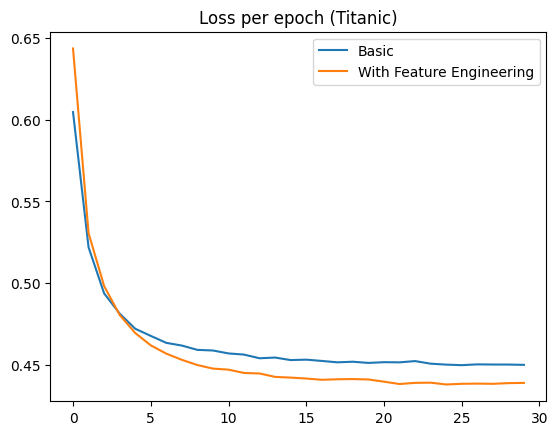

In [ ]:
loss_basic = run_experiment(
    dataset=titanic_dataset,
    model_class=LogisticRegression,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer_class=SGD,
    lr=0.1,
    batch_size=32
)

loss_fe = run_experiment(
    dataset=titanic_fe_dataset,
    model_class=LogisticRegression,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer_class=SGD,
    lr=0.1,
    batch_size=32
)

plt.plot(loss_basic, label='Basic')
plt.plot(loss_fe, label='With Feature Engineering')
plt.legend()
plt.title('Loss per epoch (Titanic)')
plt.show()


<h3>Сначало Loss у датасета с FE больше, чем у начального. К 5-10 эпохе видем, что датасет с FE начинает иметь меньшую функцию потерь, так и сохраняеться к 30 эпохе. Обучение обеих моделей останавливаеться(сильно замедляеться) примерно на 10 эпохе